#### Scan with Si Drift detector at 1cm distance, with Rh source (4mCi) and Fe10um-20um absorber

In [108]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
import time
plt.style.use('Joey')

import numpy as np
import pandas as pd
import scipy.stats as sps
import datetime as datetime

import mossbauer
import utils as u

from scipy import signal



from scipy.integrate import simpson, quad, quad_vec
from scipy.special import jv
from scipy.interpolate import interp1d
from scipy.stats import norm
from matplotlib import gridspec


from scipy.ndimage import gaussian_filter

from os.path import join

from tqdm import tqdm
from mossbauer.materials import CobaltRhodiumMatrix,NaturalIronMatrix, AlphaIron, PotassiumFerrocyanide

(0.0, 300.0)

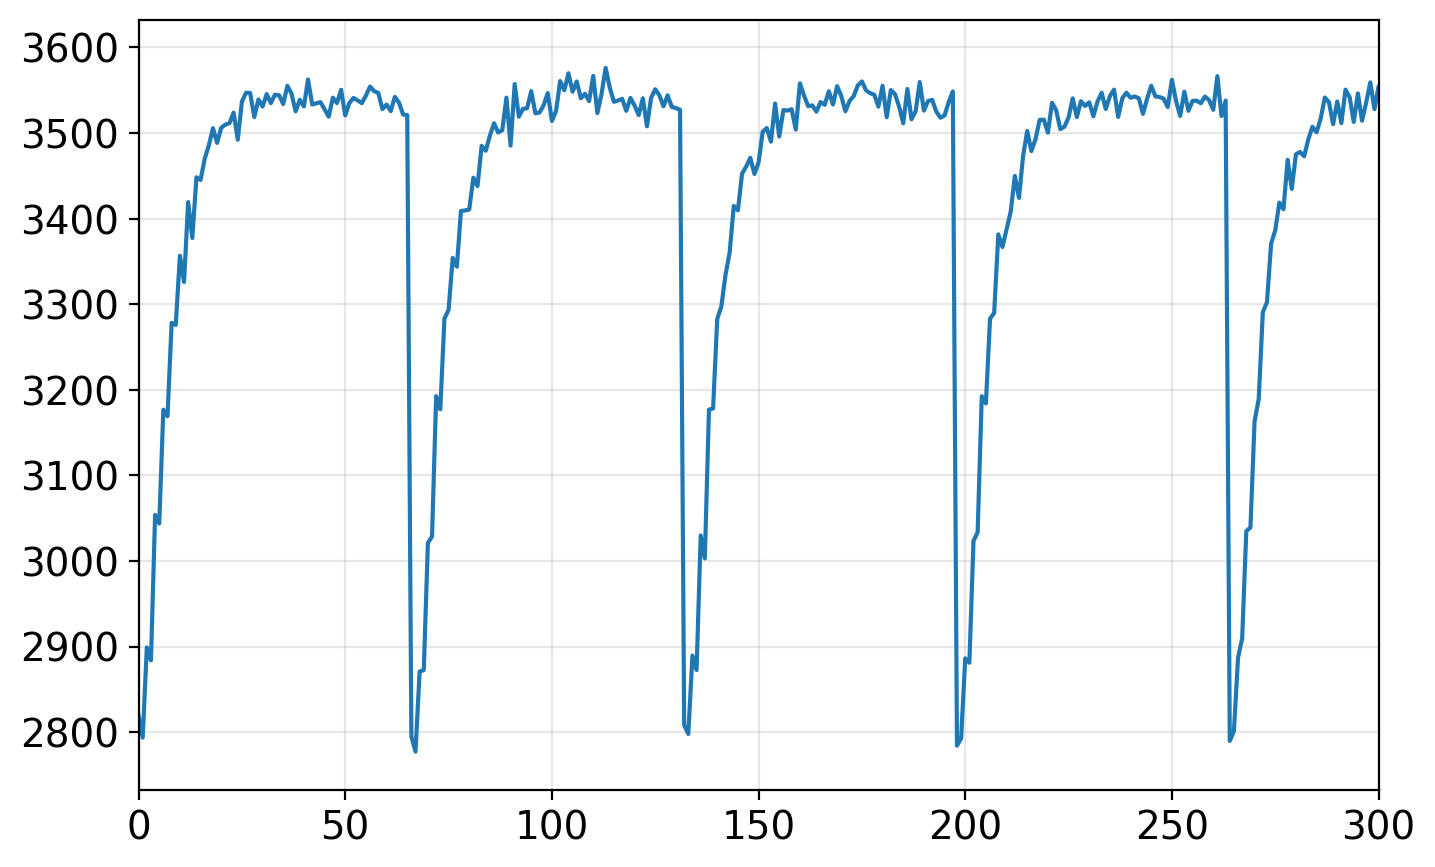

In [110]:
## Data
datadir = '/home/mossbauer/Data/mossbauer_data/'
fname = '20240214_scan/Fe20um_1BeBlank_33steps_1in.dat'
data = pd.read_csv(join(datadir, fname))
#data = data.groupby(['nominal_velocity']).sum()
#rates_m = data['count']/data['DAQ_time']
#rates_m[data.index>0] -= 0.4

plt.plot(data['count']/data['DAQ_time'])
data.groupby(['nominal_velocity']).mean()["frequency"]

750/np.sqrt(3000), 750/np.sqrt(750)
plt.xlim(0,300)


### FIT LORENTZIAN TO 25-POINT SCAN AND FIND EXPERIMENTAL PARAMETERS

currrent activity 0.002844852836550451
currrent activity 0.0033164145736382963
1.0048408537503224


E_0 = 0.752 um/s$
W = 2Gamma_0 = 0.232 mm/s
Visibility (Cmax-Cmin)/(Cmax+Cmin)) = 0.119




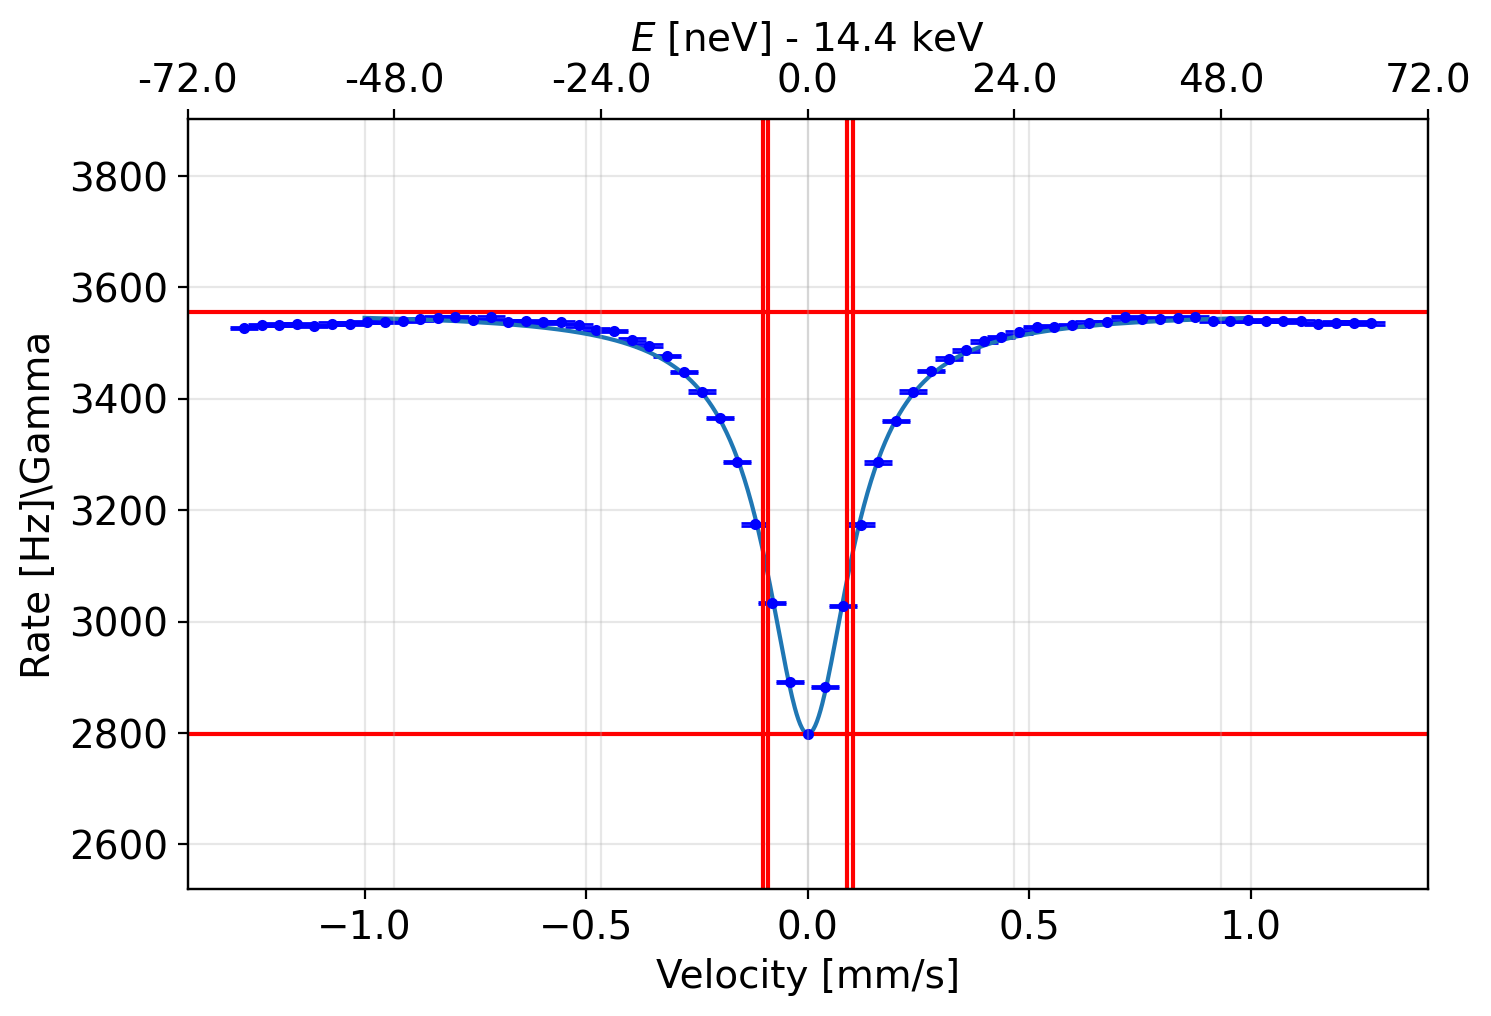

In [111]:

source = CobaltRhodiumMatrix(calibration_activity = 4.3e-3,calibration_date ="20231220");
source = NaturalIronMatrix(calibration_activity = 5e-3,calibration_date ="20231221");  # default activity is the single-line source from chemistry (2.6 mCi on 8/30/2021 decayed till today)
absorber = AlphaIron(abundance=0.022, thickness_microns=20);
#absorber = PotassiumFerrocyanide()

### measurement parameters
PMT_OD = 5  # mm
PMT_distance = 2*25.4  # mm
measurement_parameters = dict(
    acquisition_time=23.7*2*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    background_rate=1970.0,
    detection_efficiency=0.53,  # Be window * cardboard * empirical source rate difference (from background fits)
);

moss = mossbauer.MossbauerMeasurement(
    source,
    absorber,
    measurement_parameters
);


def lorentzian(p,x):
    A, B, E0, Gamma = p
    return 1/np.pi*A*Gamma/2/((x-E0)**2+(Gamma/2)**2)+B

def dlorentzian(p,x):
    A, B, E0, Gamma = p
    return -1/np.pi*A*Gamma*(x-E0)/((x-E0)**2+(Gamma/2)**2)**2



v1 = 0.08904
v2 = -0.08904

v3 = 0.10176
v4 = -0.10176
## Data
datadir = '/home/mossbauer/Data/mossbauer_data/'
fname = '20240214_scan/Fe20um_1BeBlank_33steps_1in.dat'
data = pd.read_csv(join(datadir, fname))
data = data.groupby(['nominal_velocity']).sum()
rates_m = data['count']/data['DAQ_time']
#rates_m[data.index>0] -= 0.4




fig = plt.figure()
ax = plt.gca()

vel = np.linspace(-1, 1, 1000)


plt.errorbar(
    -data.index.values,
    rates_m,
    yerr=rates_m/np.sqrt(data['count']), 
    fmt='b.',
    capsize=5
)

p0=[-100, 5000, -0.16, 0.16 ]
p,dp = u.fit(lorentzian,-data.index.values, rates_m, p0, fullout=False )
A,B,x0,gamma = p
Cmax = B
Cmin = B+2*A/(np.pi*gamma)

plt.plot(vel, lorentzian(p,vel))
#ax.plot(vel, dlorentzian(p,-Gamma/2)*(vel+Gamma)+B, color = 'b', linestyle = '--')
plt.axvline(v1,color = 'r')
plt.axvline(v2,color = 'r')
plt.axvline(v3,color = 'r')
plt.axvline(v4,color = 'r')

plt.axhline(Cmax, color = 'r')
plt.axhline(Cmin, color = 'r')

#ax2 = ax.twinx()
#ax2.plot(vel, dlorentzian(p,vel), color = 'g')
print("\n")
print('E_0 = {:.3f} um/s$'.format(x0*1000))
print('W = 2Gamma_0 = {:.3f} mm/s'.format(gamma))
print('Visibility (Cmax-Cmin)/(Cmax+Cmin)) = {:.3f}'.format((Cmax-Cmin)/(Cmax+Cmin)))
print("\n")

ax.set_ylabel('Rate [Hz]\Gamma')
ax.set_xlabel('Velocity [mm/s]')
ax.set_ylim(min(rates_m)*0.9,max(rates_m)*1.1)
mossbauer.add_energy_axis(ax)

plt.xlim(-1.5,1.5)
plt.show()


#4.7e-9/14e3/3e8
#dlorentzian(p,-Gamma/2),dlorentzian(p,vel).min(),dlorentzian(p,v1)


### CLEANUP 2-POINT SCAN DATA

In [11]:
datadir = '/home/mossbauer/Data/mossbauer_data/'
fname1 = '20240215_scan/Fe20um_1BeBlank_4steps_1in.dat'
fname2 = '20240220_scan/Fe20um_1BeBlank_4steps_1in.dat'
fname3 = '20240422_scan/Fe20um_1BeBlank_4steps_1in.dat'

fnames = [fname1,fname2,fname3]

dataframes = []
for fname in fnames:
    data = pd.read_csv(join(datadir, fname))
    #crop list
    vels = data.groupby('nominal_velocity', sort = False).mean().index
    todrop = len(data)%len(vels)
    data = data.drop(data.tail(todrop).index)
    dataframes.append(data)

data = pd.concat(dataframes).reset_index()
data


,index,count,unskimmed_count_2x,DAQ_time,nominal_velocity,frequency,fit_velocity,fit_err,fit_msr,temperature,pressure,humidity,time
0,0,52449.0,637442.0,17.142857,-0.08904,0.14,-0.088834,0.000042,0.000027,21.58,1018.74,42.0,1.708039e+09
1,1,52080.0,637442.0,17.142857,0.08904,0.14,0.088655,0.000039,0.000023,21.58,1018.74,42.0,1.708039e+09
2,2,54922.0,654272.0,17.500000,-0.10176,0.16,-0.050978,0.001829,0.034873,21.59,1018.74,42.0,1.708039e+09
3,3,54077.0,654272.0,17.500000,0.10176,0.16,0.051065,0.001812,0.034218,21.59,1018.74,42.0,1.708039e+09
4,4,52723.0,638914.0,17.142857,-0.08904,0.14,-0.088842,0.000042,0.000028,21.57,1018.74,42.0,1.708039e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262655,8439,50542.0,584302.0,17.500000,0.10176,0.16,0.050152,0.001814,0.035892,21.53,1014.46,40.8,1.713993e+09
262656,8440,49189.0,571911.0,17.142857,-0.08904,0.14,-0.088681,0.000057,0.000052,21.54,1014.44,40.8,1.713993e+09
262657,8441,49011.0,571911.0,17.142857,0.08904,0.14,0.088626,0.000051,0.000042,21.54,1014.44,40.8,1.713993e+09
262658,8442,51066.0,584915.0,17.500000,-0.10176,0.16,-0.050080,0.001828,0.036428,21.54,1014.44,41.0,1.713993e+09


In [92]:
datadir = '/home/mossbauer/Data/mossbauer_data/'
fname1 = '20240215_scan/Fe20um_1BeBlank_4steps_1in.dat'
fname2 = '20240220_scan/Fe20um_1BeBlank_4steps_1in.dat'
fname3 = '20240422_scan/Fe20um_1BeBlank_4steps_1in.dat'
fname4 = '20240430_scan/Fe20um_1BeBlank_4steps_1in1.dat'
fname5 = '20240430_scan/Fe20um_1BeBlank_4steps_1in2.dat'

fnames = [fname1,fname2,fname3]#,fname4]#,fname5]

dataframes = []
for fname in fnames:
    data = pd.read_csv(join(datadir, fname))
    #crop list
    vels = data.groupby('nominal_velocity', sort = False).mean().index
    todrop = len(data)%len(vels)
    data = data.drop(data.tail(todrop).index)
    dataframes.append(data)

data = pd.concat(dataframes).reset_index()

idxall = []

vels = data.groupby('nominal_velocity', sort = False).mean().index
times = data.groupby('nominal_velocity', sort = False).mean()['DAQ_time']

#drop manually 
#data = data.drop([414,415]).reset_index()

for i,v in enumerate(vels):
    counts = data[data['nominal_velocity']==v]['count'].values
    mean = counts.mean()
    std = counts.std()
    idx = [j for j, c in enumerate(np.abs((counts-mean)/std)) if c>5]
    idx = list(np.array(idx)*len(vels))
    for k in range(len(vels)):
        idxall+=[x+k for x in idx]
    
print('eliminated points: ',len(idxall))
        
    
data = data.drop(idxall)
clean_name = datadir + fname[:-4]+'_clean.dat'
data.to_csv(clean_name)
print(clean_name)


#plt.plot(data['count']/data['DAQ_time'])

#print(vels)
#data


#counts_all = data["unskimmed_count_2x"][::2].values
#counts_v1 = data[data['nominal_velocity']==v1]['count'].values
#counts_v2 = data[data['nominal_velocity']==v2]['count'].values

#counts_v3 = data[data['nominal_velocity']==v3]['count'].values
#counts_v4 = data[data['nominal_velocity']==v4]['count'].values

#len(counts_v1),len(counts_v2),len(counts_v3),len(counts_v4)

eliminated points:  28
/home/mossbauer/Data/mossbauer_data/20240422_scan/Fe20um_1BeBlank_4steps_1in_clean.dat


### FIRST PLOT AND SENSITIVITY

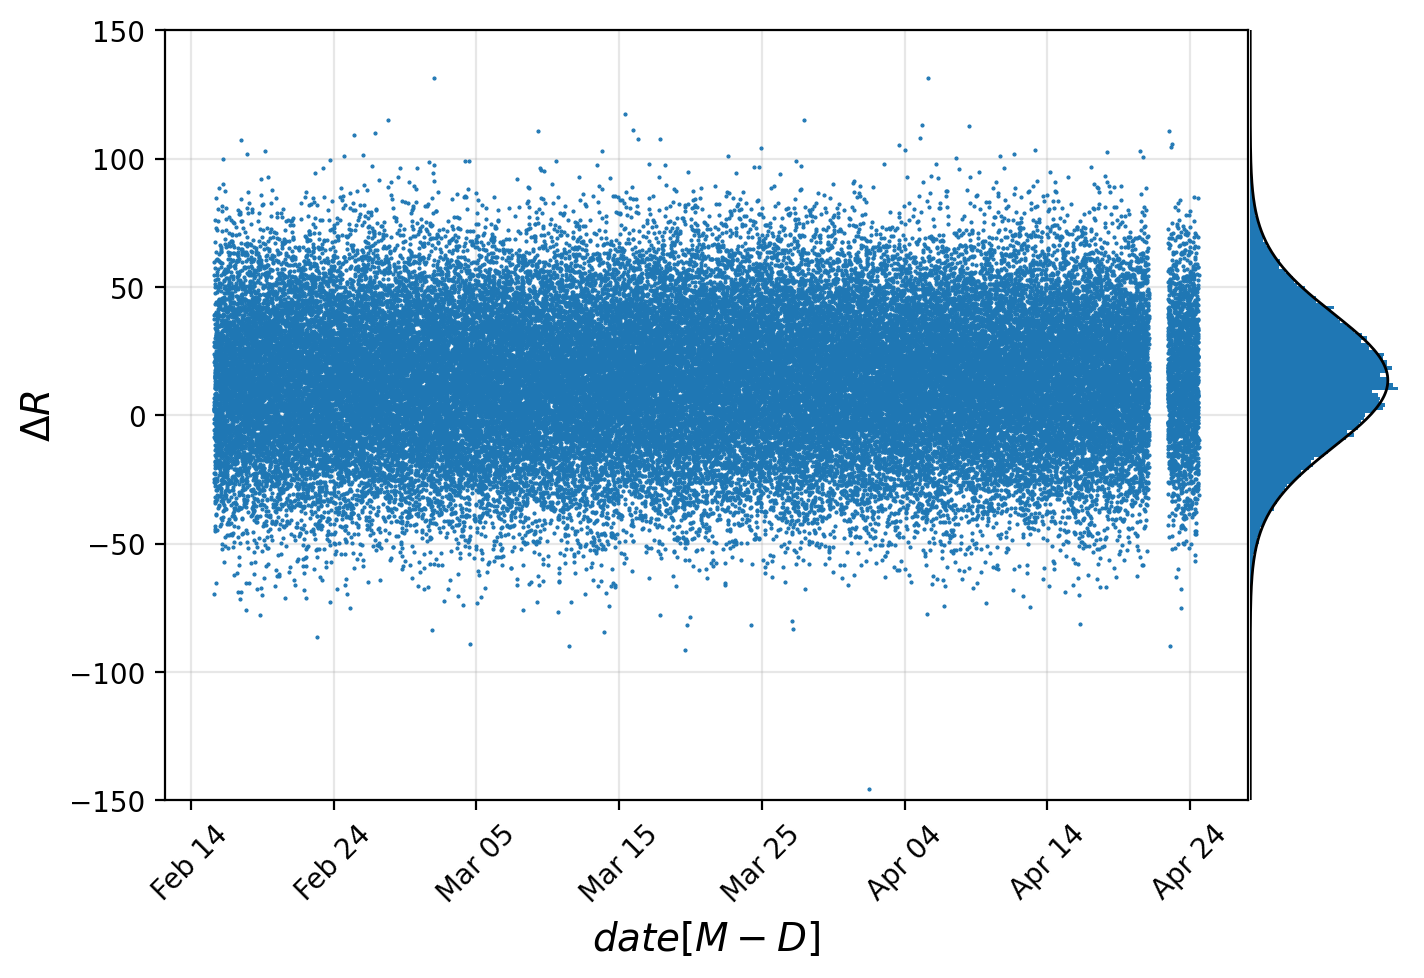

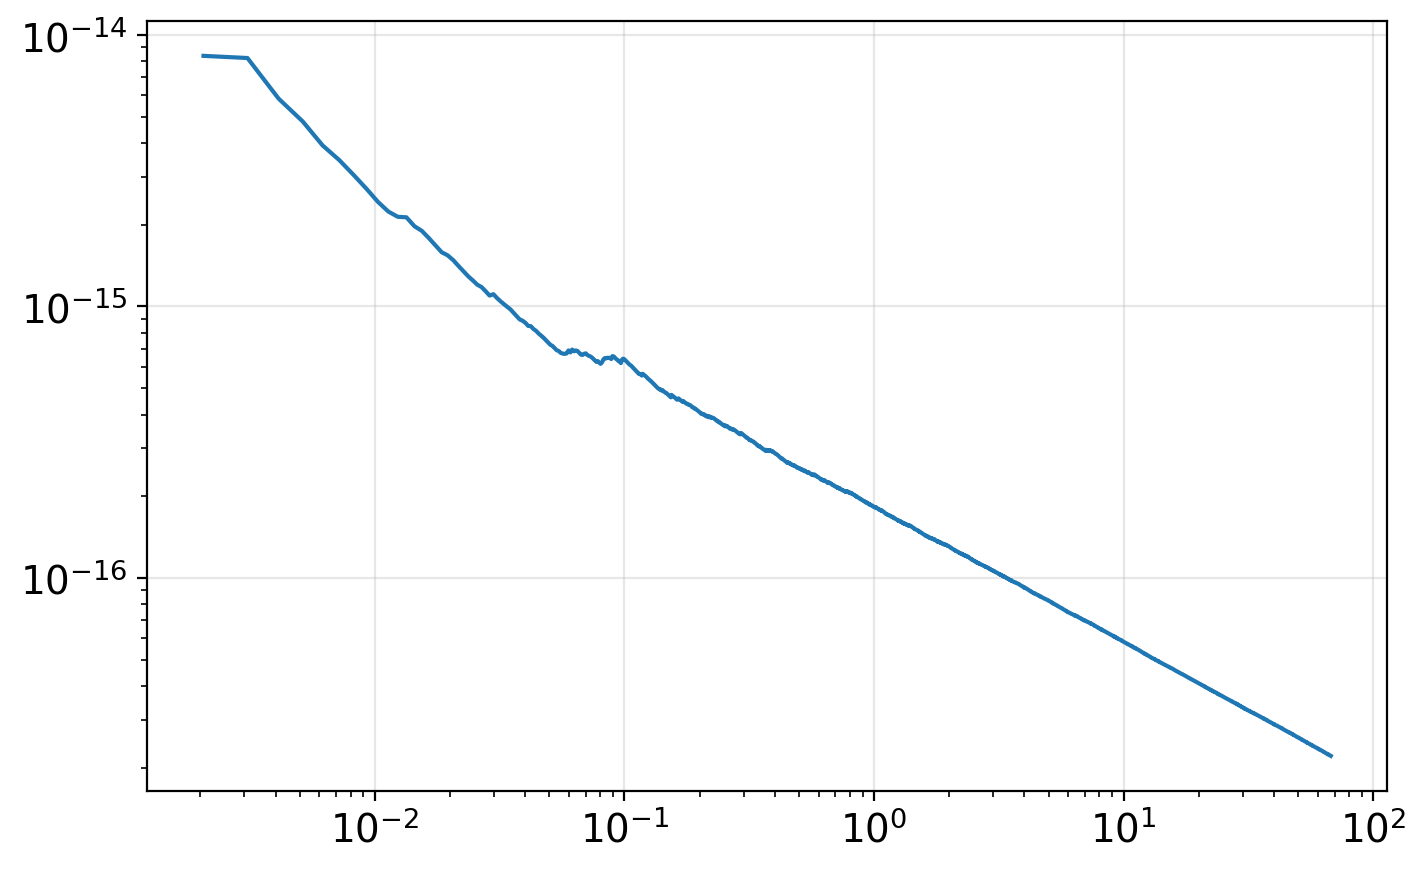

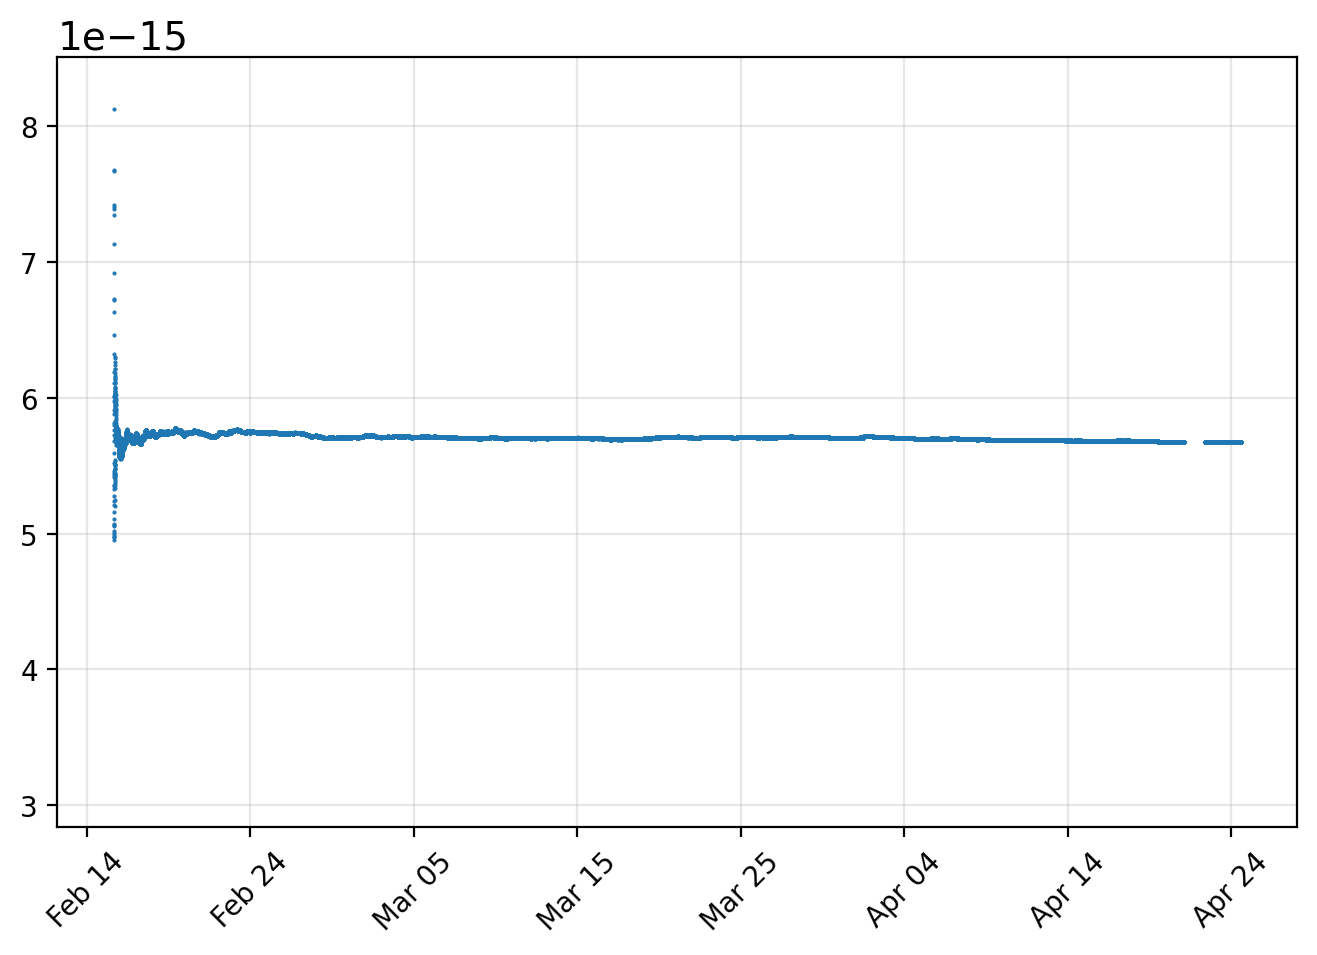

In [93]:
fname = '20240422_scan/Fe20um_1BeBlank_4steps_1in_clean.dat'
fname = clean_name

data = pd.read_csv(join(datadir, fname))

#carefu, channels are inverted!
v1 = 0.08904
v2 = -0.08904

v3 = 0.10176
v4 = -0.10176

counts_all = data["unskimmed_count_2x"][::2].values
counts_v1 = data[data['nominal_velocity']==v1]['count'].values
counts_v2 = data[data['nominal_velocity']==v2]['count'].values

counts_v3 = data[data['nominal_velocity']==v3]['count'].values
counts_v4 = data[data['nominal_velocity']==v4]['count'].values

timestamps = data[data['nominal_velocity']==v1]['time'].values
dates=[datetime.datetime.fromtimestamp(ts) for ts in timestamps]

diff = counts_v1/times[v1]-counts_v2/times[v2] + (counts_v3/times[v3]-counts_v4/times[v4])

fig = plt.figure()
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[7, 1])

ax1 = fig.add_subplot(spec[0])


ax1.plot(dates, diff,'.',markersize = 1)
plt.xticks(rotation=45, fontsize = 10)
plt.yticks(fontsize = 10)


xfmt = md.DateFormatter('%b %d', )
ax1.xaxis.set_major_formatter(xfmt)
ax1.xaxis.set_major_locator(md.DayLocator(interval=10))


ax2 = fig.add_subplot(spec[1], sharey = ax1)
h,b, pat  = plt.hist(diff, bins =300,density=True, orientation=u'horizontal',label='difference')
mu, std = norm.fit(diff)
ax2.plot(norm.pdf(np.linspace(-500,500,1000), mu, std), np.linspace(-500,500,1000), color = 'k',linewidth=1)

#plt.ylim(min(diff)-10,max(diff)+10)
plt.ylim(-150,150)

fig.subplots_adjust(wspace=0.004)
ax2.axis('off')



dRdE_v1 = dlorentzian(p,v1)
dRdE_v2 = dlorentzian(p,v2)
dRdE_v3 = dlorentzian(p,v3)
dRdE_v4 = dlorentzian(p,v4)

dRdE_diff = dRdE_v1 - dRdE_v2 + dRdE_v3 - dRdE_v4

ax1.set_ylabel('$\Delta R$')
ax1.set_xlabel('$date [M-D]$')
plt.show()



n = pd.Series(diff).index.values[1:]+1
cumulative_time = n*(timestamps[1]-timestamps[0])

cumstd = pd.Series(diff).expanding().std()[1:].values/np.abs(dRdE_diff)/3e11
sens = cumstd/np.sqrt(n)

#np.savetxt(datadir + fname[:-4]+'_sensitivityvstime.dat', [cumulative_time,sens])
plt.plot(cumulative_time/3600/24,sens)

deltaT = 1000e-3
#plt.axhline(deltaT/(14e3/1e-11)*(temp/300)**3)

deltaT = 100e-3
#plt.axhline(deltaT/(14e3/1e-11)*(temp/300)**3)

deltaT = 10e-3
#plt.axhline(deltaT/(14e3/1e-11)*(temp/300)**3)

plt.yscale("log")
plt.xscale("log")
plt.show()

plt.figure()
ax1=plt.gca()
plt.plot(dates[1:], cumstd,'.',markersize = 1)
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(cumstd[-1]*0.5,cumstd[-1]*1.5)

plt.xticks(rotation=45, fontsize = 10)
plt.yticks(fontsize = 10)


xfmt = md.DateFormatter('%b %d', )
ax1.xaxis.set_major_formatter(xfmt)
ax1.xaxis.set_major_locator(md.DayLocator(interval=10))





THP

In [97]:
mu, std, std/dRdE_diff/3e11, len(diff), std/np.sqrt(len(diff))/dRdE_diff/3e11, 


temp = 292
currentDT = (sens[-1]*14e3/1e-11)/(temp/300)**3
requiredDT = (1e-19*14e3/1e-11)/(temp/300)**3

print("Current sensitivity $\DeltaE$  = {:.2e} nm/s".format(sens[-1]*3e17))
print("Current sensitivity $\DeltaE$  = {:.2e} eV".format(sens[-1]*14.4e3))
print("Current sensitivity $\DeltaE/E$  = {:.2e}".format(sens[-1]))
print("Current temperature diffference stability  < {:.2f} mK".format(currentDT*1e3))
print("Required temperature diffference stability = {:.2f} mK".format(requiredDT*1e3))


#Tlever
0.5/currentDT

mu, std, std/dRdE_diff/3e11, len(diff), std/np.sqrt(len(diff))/dRdE_diff/3e11, 


std

Current sensitivity $\DeltaE$  = 6.64e+00 nm/s
Current sensitivity $\DeltaE$  = 3.19e-13 eV
Current sensitivity $\DeltaE/E$  = 2.21e-17
Current temperature diffference stability  < 33.61 mK
Required temperature diffference stability = 0.15 mK


25.923652006418532

In [95]:
#chi2 = ((h - norm.pdf(b[1:], mu, std))**2/norm.pdf(b[1:], mu, std))
#chi2 = (h - norm.pdf(b[1:], mu, std))**2/std**2

diff = counts_v1/times[v1]-counts_v2/times[v2] + (counts_v3/times[v3]-counts_v4/times[v4])

chi2 =  (diff-mu)**2/std**2
chi2.sum(),len(chi2)

samp = diff[:]

sigma = np.sqrt(counts_v1/times[v1]**2+counts_v2/times[v2]**2+counts_v3/times[v3]**2+counts_v4/times[v4]**2)

((diff-mu)**2/(sigma)**2).sum()/(len(diff)-1)
#mu

0.9717080347855981

In [61]:
sigma.mean(), std

(26.2970708769319, 25.923652006418532)

(datetime.datetime(2024, 4, 21, 2, 30, 46, 926378),
 datetime.datetime(2024, 4, 22, 10, 15, 23, 552248))

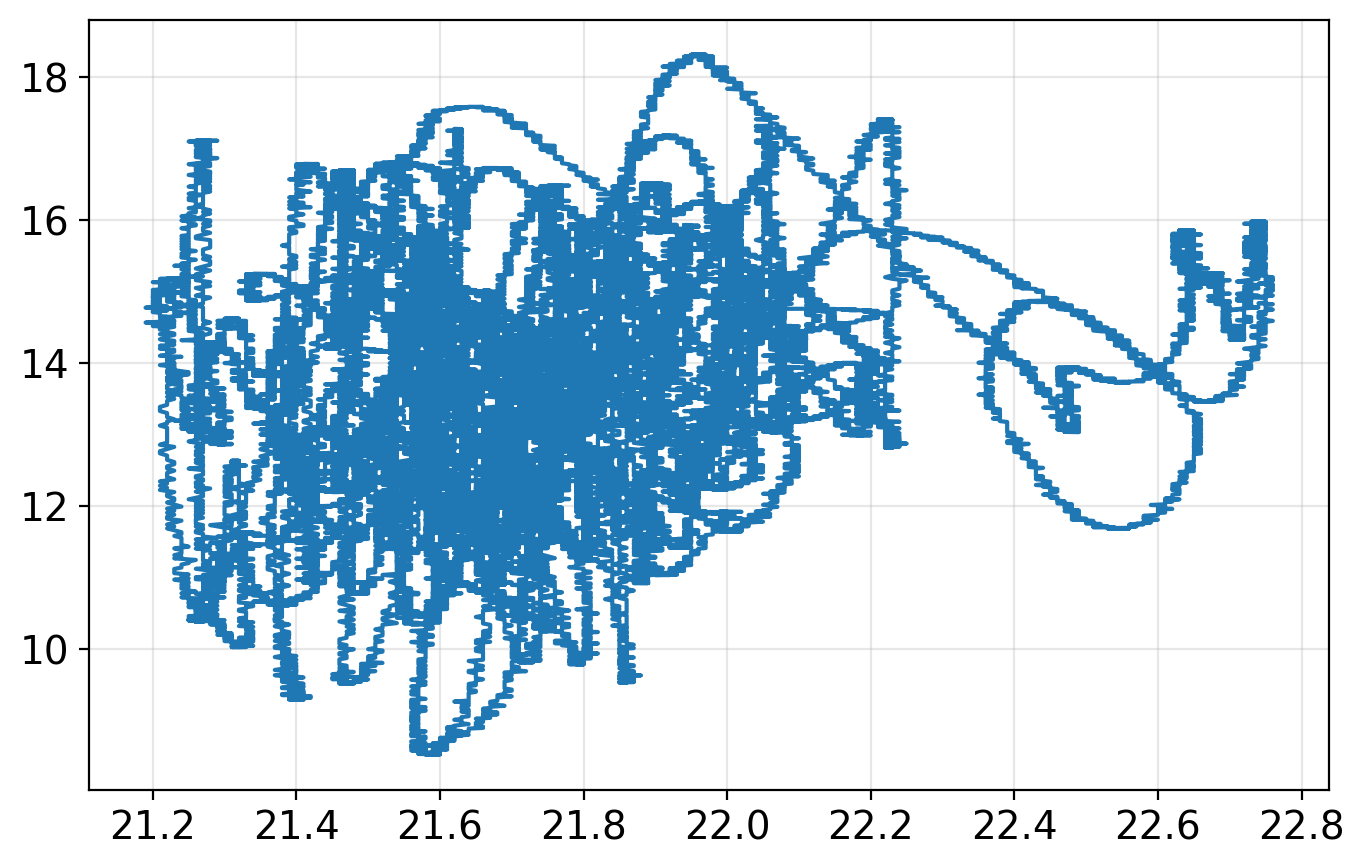

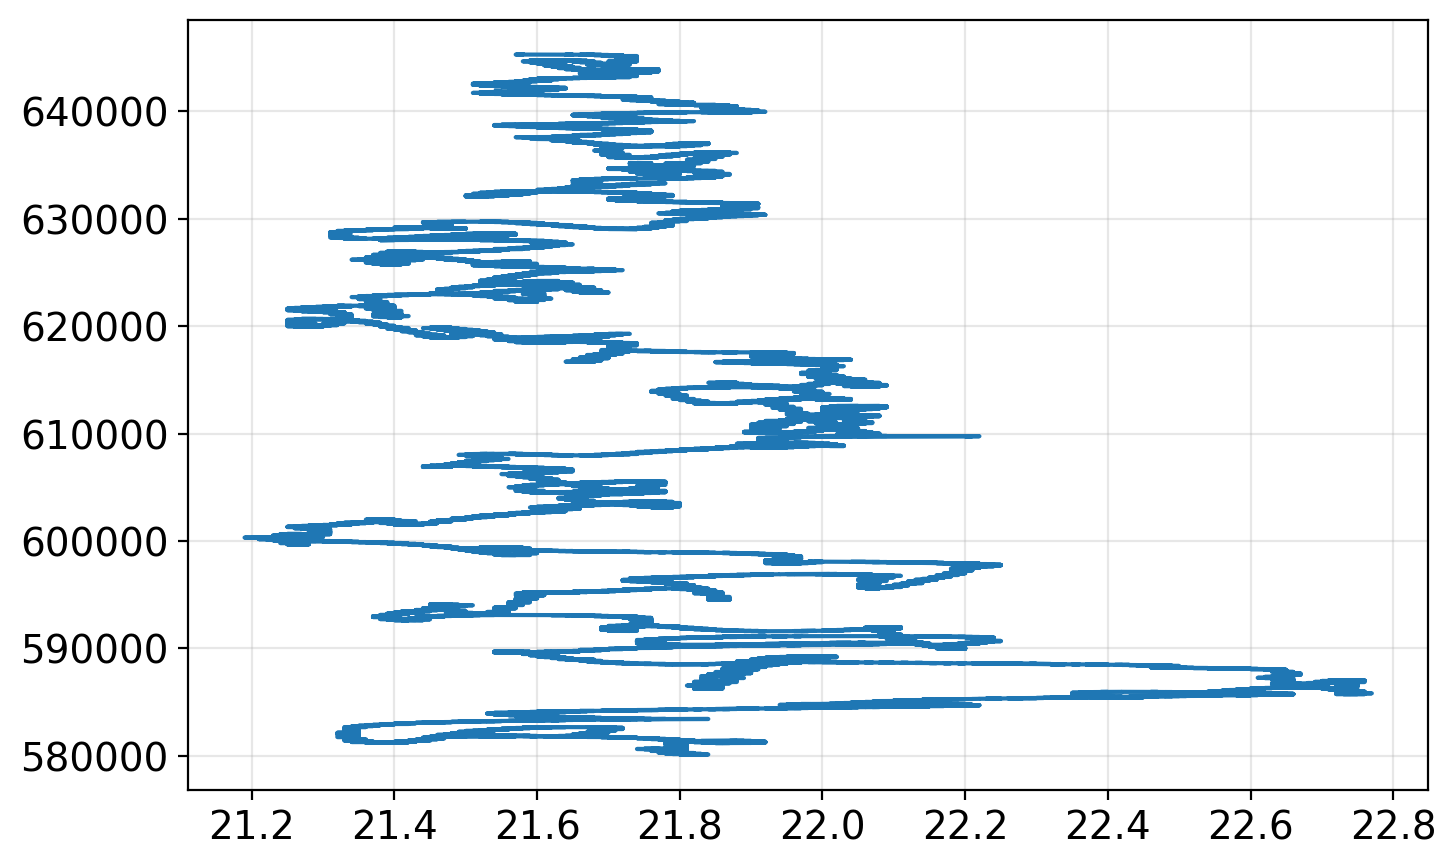

In [517]:
counts_v1 = data[data['nominal_velocity']==v1]['count'].values
counts_v2 = data[data['nominal_velocity']==v2]['count'].values
counts_v3 = data[data['nominal_velocity']==v3]['count'].values
counts_v4 = data[data['nominal_velocity']==v4]['count'].values

timestamps = data[data['nominal_velocity']==v1]['time'].values
dates=[datetime.datetime.fromtimestamp(ts) for ts in timestamps]
dt = timestamps[1]-timestamps[0]

diff = counts_v1/times[v1]-counts_v2/times[v2] + (counts_v3/times[v3]-counts_v4/times[v4])
temp = data['temperature'].values[::4]


plt.plot(temp,gaussian_filter(diff,100))

plt.figure()

unskimmed2 = data["unskimmed_count_2x"].values
temp2 = data['temperature'].values

plt.plot(temp2,gaussian_filter(unskimmed2,400))


dates[-1],datetime.datetime.fromtimestamp(time.time())

<Figure size 800x500 with 0 Axes>

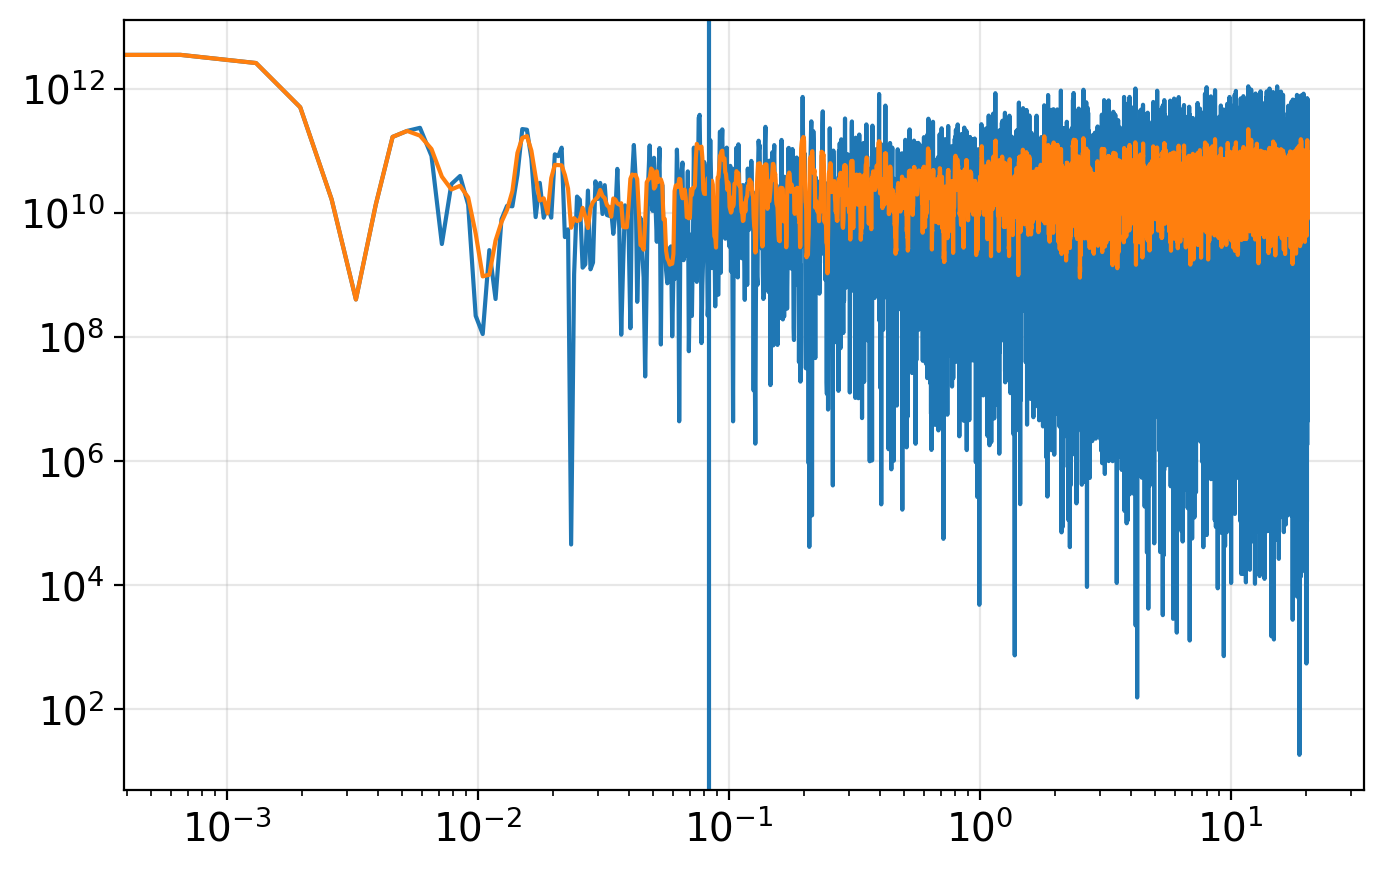

<Figure size 800x500 with 0 Axes>

In [448]:
def smoothen_spectrum(x):
    smoothened = [None for k in range(len(x))]
    for j in range(len(x)):
        delta = int(np.log(j/5+1))
        #delta = int(np.log(j/1000+1))
        #delta = 0
        if j + delta >= len(x):
            smoothened[j]=np.mean(x[j-delta:])
        else:
            smoothened[j] = np.mean(x[j-delta:j+delta+1])
    return smoothened


#diff = data["unskimmed_count_2x"][::4].values

nperseg = len(diff)

f, psdx = signal.welch(temp, 1/dt, nperseg = nperseg)
f, psdy = signal.welch(diff, 1/dt, nperseg = nperseg)

f, csdxy = signal.csd(temp, diff, 1/dt, nperseg=nperseg)

#plt.loglog(f,psdx)
#plt.loglog(f,psdy)
plt.loglog(f*3600,np.abs(csdxy**2/psdx*psdy))
plt.loglog(f*3600,smoothen_spectrum(np.abs(csdxy**2/psdx*psdy)))
plt.axvline(x = 1/12)
#plt.xlim(100,0.01)
plt.figure()

#plt.semilogx(1/f[::-1]/3600,np.angle(csdxy**2/psdx*psdy)/2/np.pi)

<Figure size 800x500 with 0 Axes>

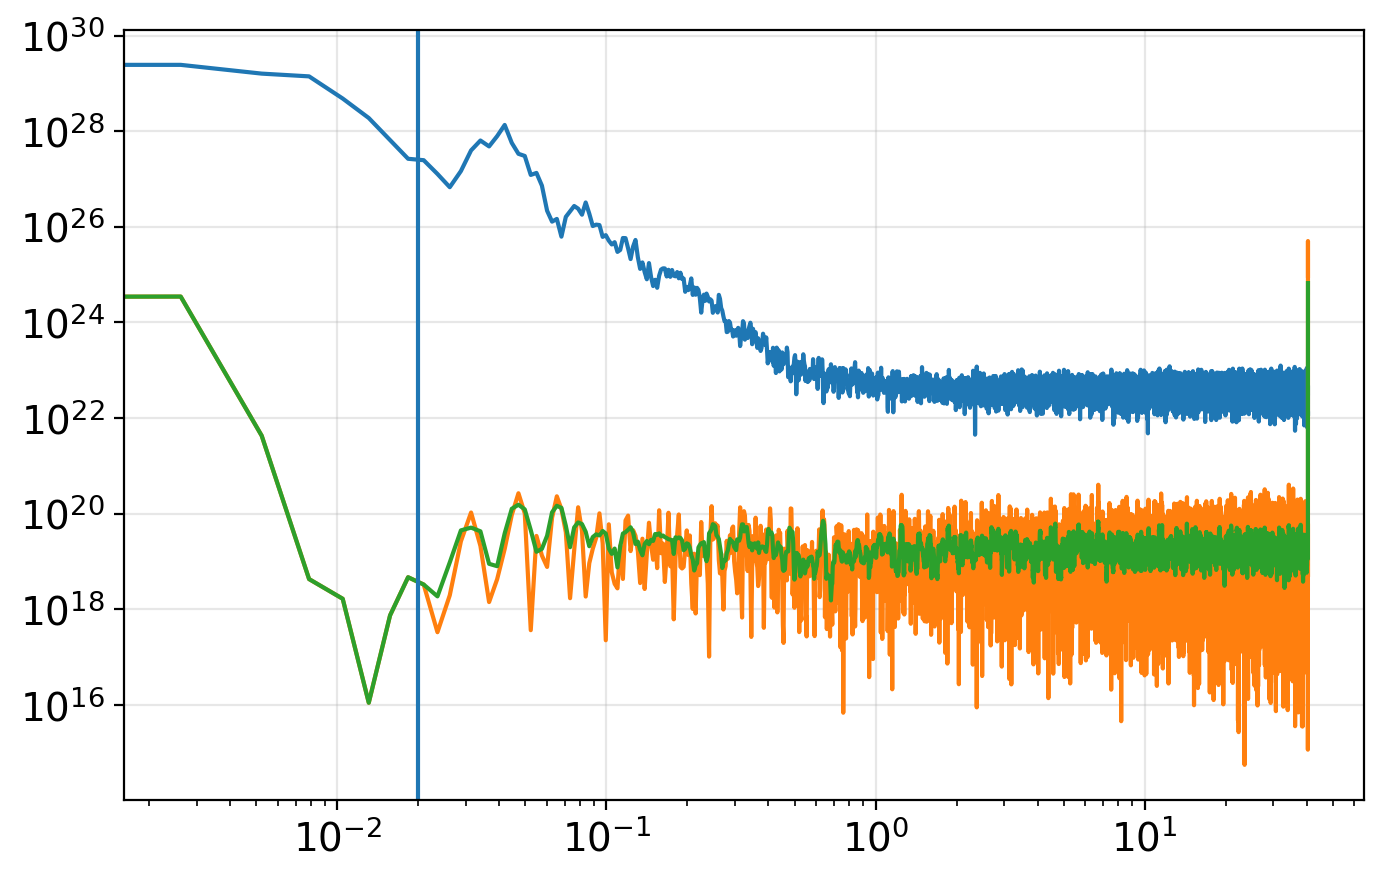

<Figure size 800x500 with 0 Axes>

In [503]:



unskimmed2 = data["unskimmed_count_2x"][::2].values
temp2 = data['temperature'][::2].values

dt2=dt/2
nperseg = len(diff)//2


f, psdx = signal.welch(temp2, 1/dt2, nperseg = nperseg)
f, psdy = signal.welch(unskimmed2, 1/dt2, nperseg = nperseg)

f, csdxy = signal.csd(temp2, unskimmed2, 1/dt2, nperseg=nperseg)

plt.loglog(f*3600,psdx*1e25)
#plt.loglog(f,psdy)
plt.loglog(f*3600,np.abs(csdxy**2/psdx*psdy))
plt.loglog(f*3600,smoothen_spectrum(np.abs(csdxy**2/psdx*psdy)))
plt.axvline(x = 1/50)

#plt.xlim(100,0.01)
plt.figure()

#plt.semilogx(1/f[::-1]/3600,np.angle(csdxy**2/psdx*psdy)/2/np.pi)

Text(0.5, 0, 'Date [M-D]')

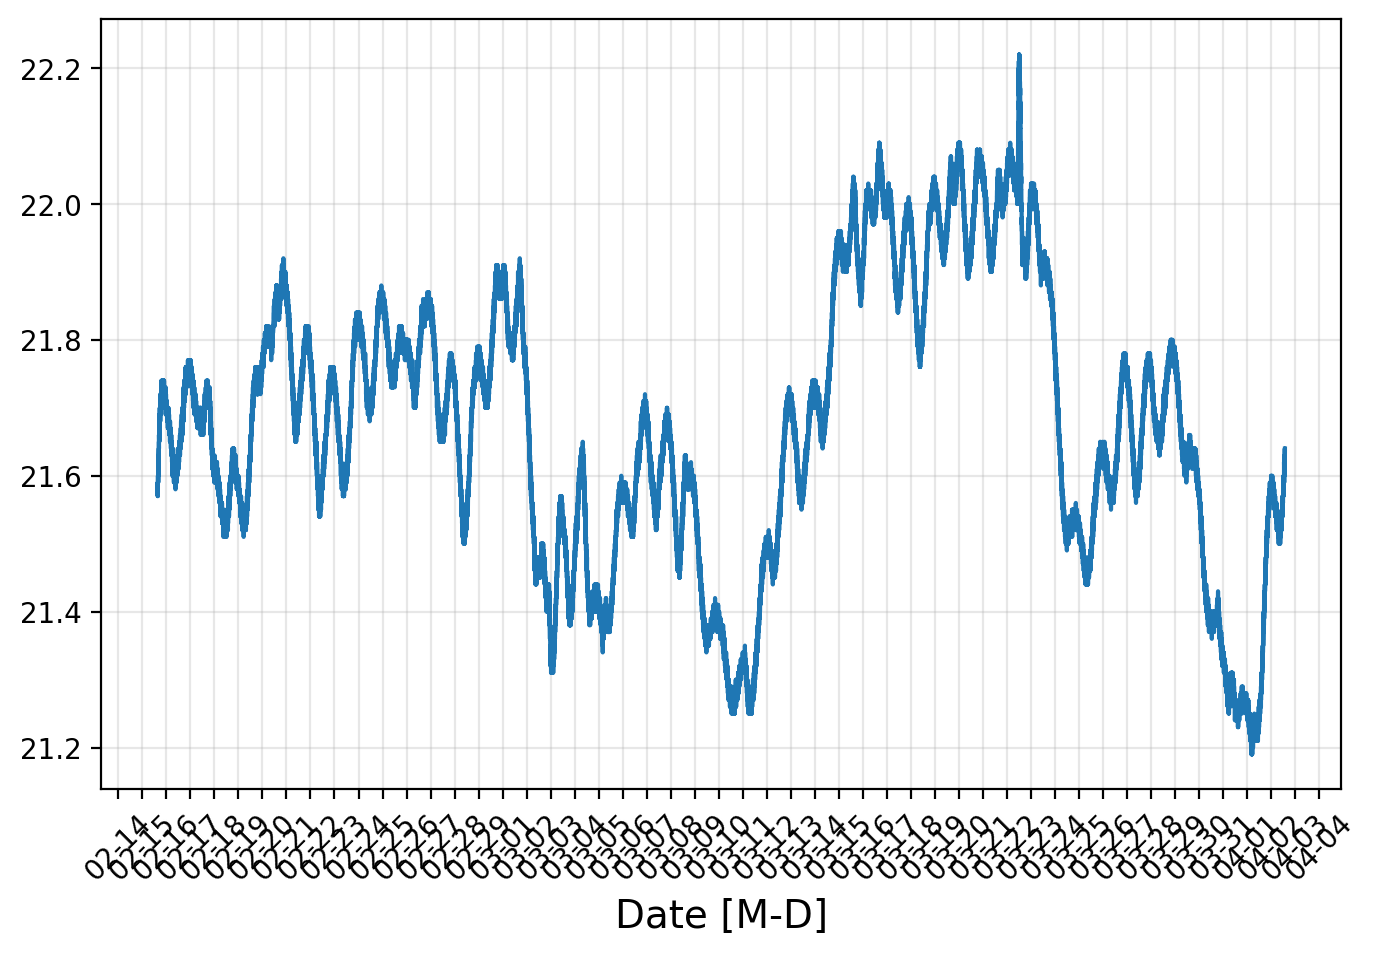

In [297]:

timestamps = data['time'].values
dates=[datetime.datetime.fromtimestamp(ts) for ts in timestamps]

plt.figure()
ax = plt.gca()


#ax2 = ax.twinx()
#ax2.plot(dates,data['pressure'].values, color = 'g')
#ax2.set_xticks([])



plt.plot(dates,data['temperature'].values)
#plt.ylabel("Temperature [$\degree$C]")



xfmt = md.DateFormatter('%m-%d', )
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis.set_major_locator(md.DayLocator(interval=1))

plt.xticks(rotation=45, fontsize = 10);
plt.yticks(fontsize = 10);




plt.xlabel('Date [M-D]')
#plt.xlim(2024-02-14,2024-02-15)
#ax.axhline(22.000, color = 'r')
#ax.axhline(22.001, color = 'r')



(1.5158908966548073e-07, 1.7543548923166667e-07)

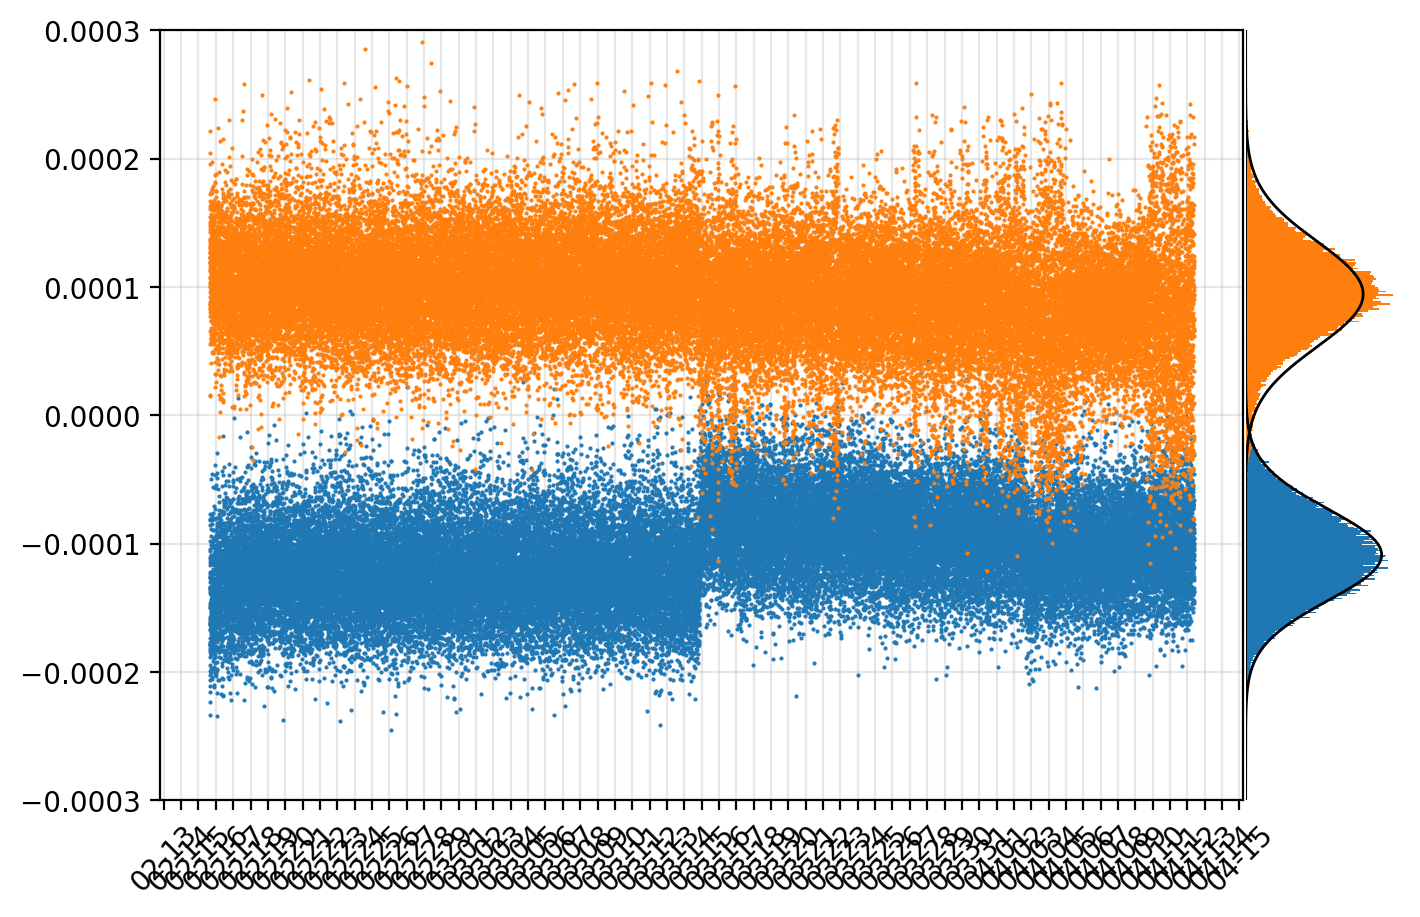

In [320]:
fit_v1 = data[data['nominal_velocity']==v1]['fit_velocity'].values
fit_v2 = data[data['nominal_velocity']==v2]['fit_velocity'].values
fit_v3 = data[data['nominal_velocity']==v3]['fit_velocity'].values
fit_v4 = data[data['nominal_velocity']==v4]['fit_velocity'].values

temp = data[data['nominal_velocity']==v4]['temperature'].values

timestamps = data[data['nominal_velocity']==v1]['time'].values
dates=[datetime.datetime.fromtimestamp(ts) for ts in timestamps]

diff_v1 = fit_v1+fit_v2
diff_v2 = fit_v3+fit_v4




fig = plt.figure()
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[7, 1])

ax1 = fig.add_subplot(spec[0])
ax1.plot(dates, diff_v1,'.',markersize = 1)
ax1.plot(dates, diff_v2,'.',markersize = 1)
plt.xticks(rotation=45, fontsize = 10)
plt.yticks(fontsize = 10)


xfmt = md.DateFormatter('%m-%d', )
ax1.xaxis.set_major_formatter(xfmt)
ax1.xaxis.set_major_locator(md.DayLocator(interval=1))


ax2 = fig.add_subplot(spec[1], sharey = ax1)
h,b, pat  = plt.hist(diff_v1, bins =300,density=True, orientation=u'horizontal',label='difference')
mu1, std1 = norm.fit(diff_v1)
ax2.plot(norm.pdf(np.linspace(-3e-4,3e-4,1000), mu1, std1), np.linspace(-3e-4,3e-4,1000), color = 'k',linewidth=1)

h,b, pat  = plt.hist(diff_v2, bins =300,density=True, orientation=u'horizontal',label='difference')
mu2, std2 = norm.fit(diff_v2)
ax2.plot(norm.pdf(np.linspace(-3e-4,3e-4,1000), mu2, std2), np.linspace(-3e-4,3e-4,1000), color = 'k',linewidth=1)


plt.ylim(-3e-4,3e-4)

fig.subplots_adjust(wspace=0.004)
ax2.axis('off')

std1/np.sqrt(len(diff_v1)), std2/np.sqrt(len(diff_v1))

In [6]:
fit_v1 = data[data['nominal_velocity']==v1]['fit_velocity'].values
fit_v2 = data[data['nominal_velocity']==v2]['fit_velocity'].values
fit_v3 = data[data['nominal_velocity']==v3]['fit_velocity'].values
fit_v4 = data[data['nominal_velocity']==v4]['fit_velocity'].values

temp = data[data['nominal_velocity']==v4]['temperature'].values
pres = data[data['nominal_velocity']==v4]['pressure'].values
hum = data[data['nominal_velocity']==v4]['humidity'].values

plt.plot(dates,fit_v1,'.',markersize =1)
plt.plot(dates, -fit_v2,'.',markersize =1)


ax1 = plt.gca()
ax2 = ax1.twinx()

ax2.plot(dates,temp)
#ax2.plot(dates,pres)
#ax2.plot(dates,hum)


ax1 = plt.gca()

xfmt = md.DateFormatter('%m-%d', )
ax1.xaxis.set_major_formatter(xfmt)
ax1.xaxis.set_major_locator(md.DayLocator(interval=1))
plt.xticks(rotation=45, fontsize = 10)
plt.yticks(fontsize = 10)

#plt.xlim(27200,27600)

#plt.figure()

#plt.plot(dates, fit_v3,'.',markersize =1)
#plt.plot(dates, -fit_v4,'.',markersize =1)
#plt.xlim(0,10000)

NameError: name 'v1' is not defined

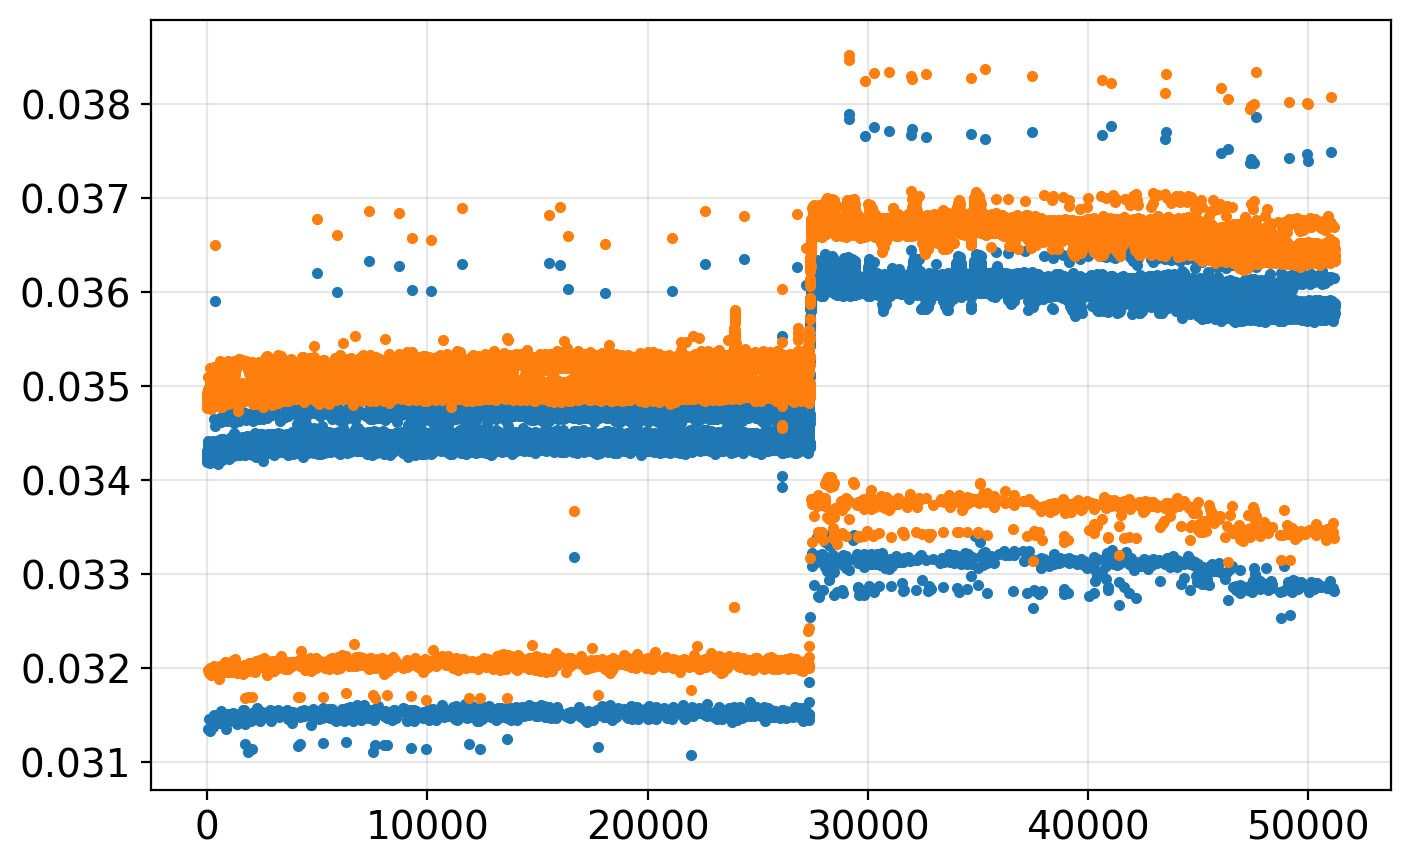

In [307]:
fit_v1 = data[data['nominal_velocity']==v1]['fit_msr'].values
fit_v2 = data[data['nominal_velocity']==v2]['fit_msr'].values
fit_v3 = data[data['nominal_velocity']==v3]['fit_msr'].values
fit_v4 = data[data['nominal_velocity']==v4]['fit_msr'].values

#plt.plot(fit_v1,'.')
#plt.plot(-fit_v2,'.')
plt.plot(fit_v3,'.')
plt.plot(fit_v4,'.')
#plt.xlim(0,100)

(17.142857142857142,
 17.142857142857142,
 17.5,
 17.5,
 0.08904,
 -0.08904,
 0.10176,
 -0.10176,
 131322,
 65661)

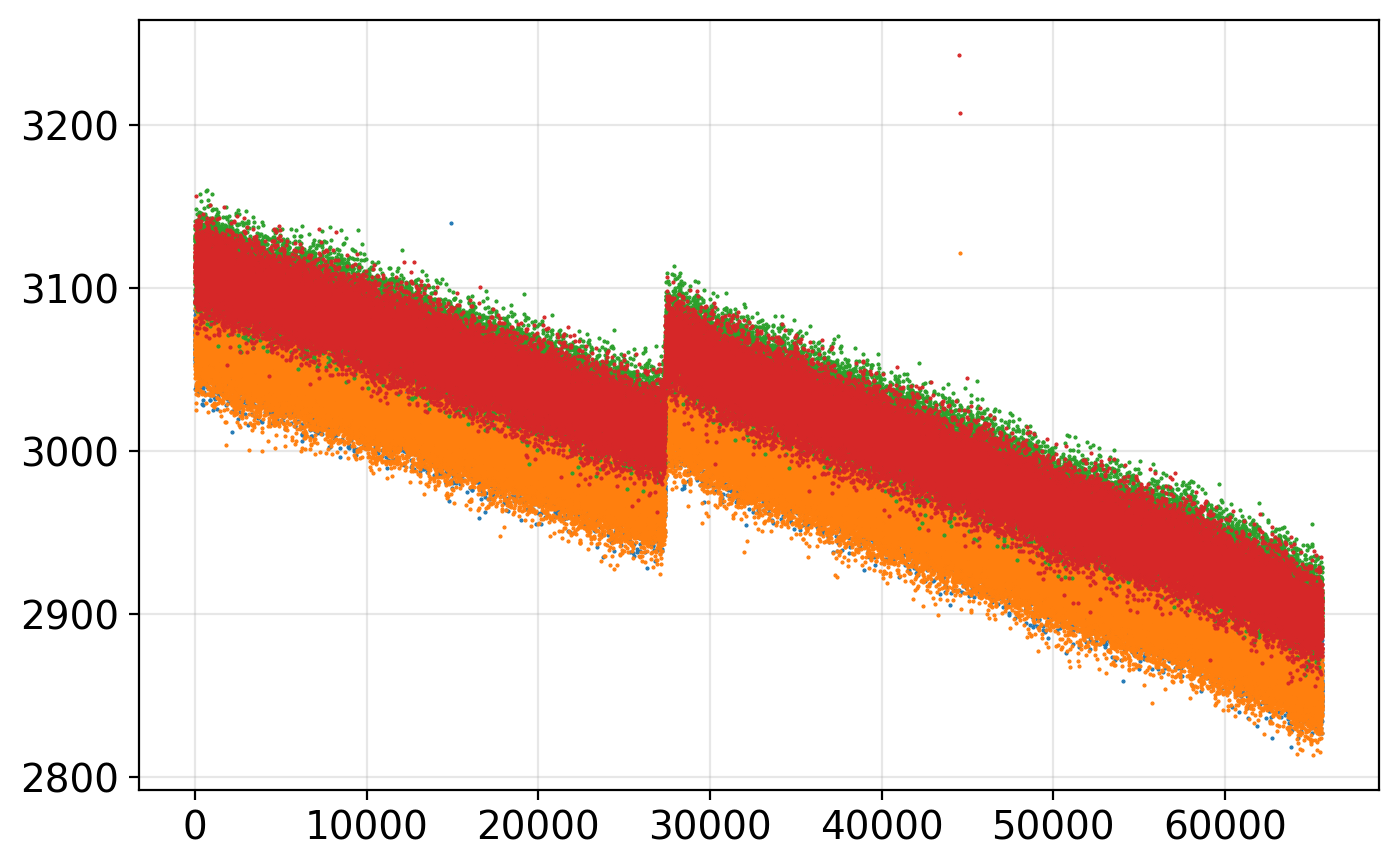

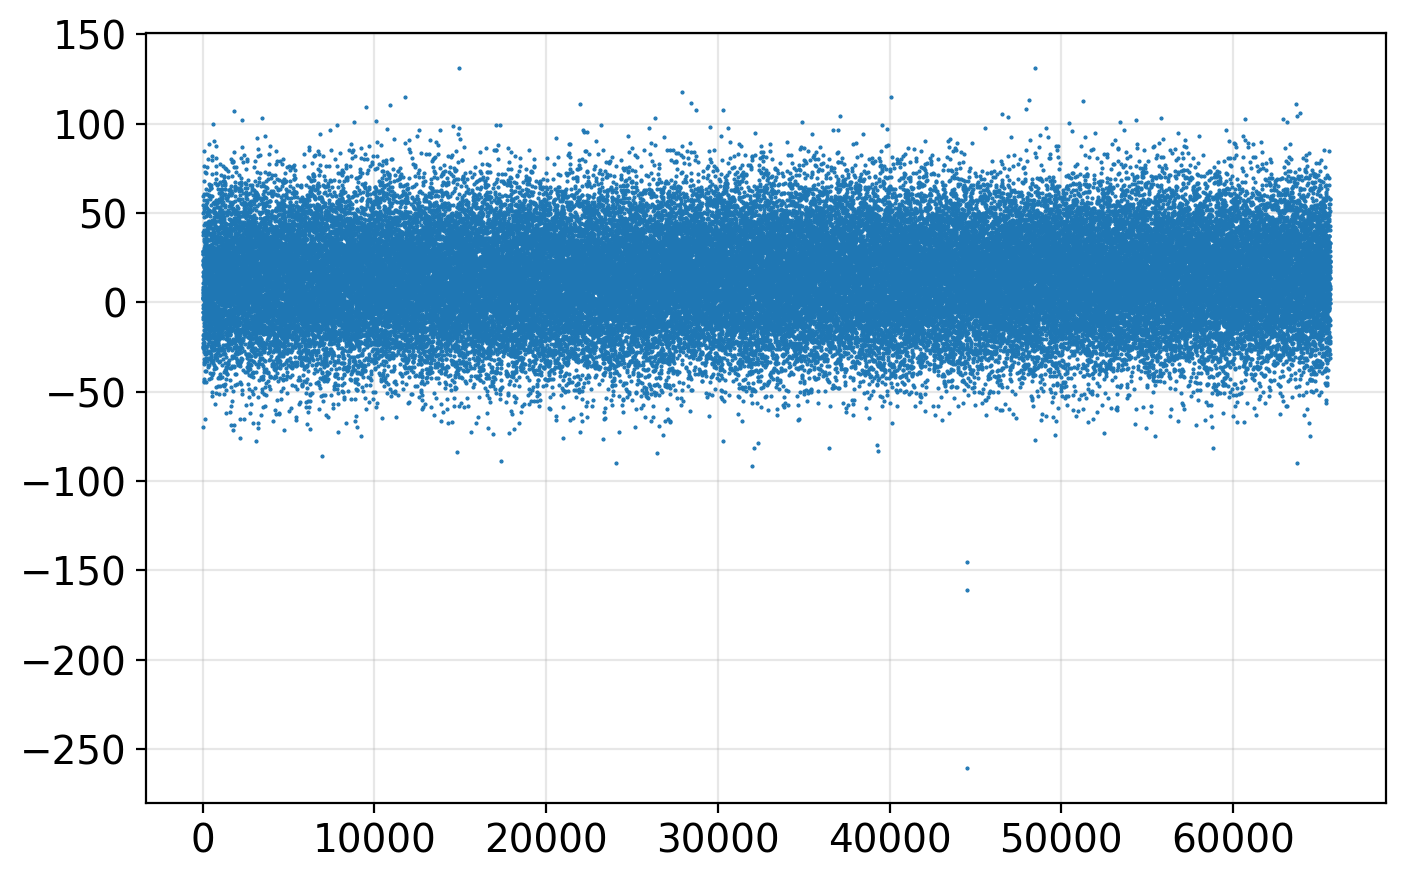

In [14]:
A = counts_v1/times[-v1]
B = counts_v2/times[-v2]
C = counts_v3/times[-v3]
D = counts_v4/times[-v4]

dates=[datetime.datetime.fromtimestamp(ts) for ts in timestamps]


plt.plot(A,'.', markersize = 1)
plt.plot(B,'.', markersize = 1)
plt.plot(C,'.', markersize = 1)
plt.plot(D,'.', markersize = 1)

counts_all = data["unskimmed_count_2x"][::2].values
#plt.xlim(20000,40000)
#print(dates[27350],dates[27400])

plt.figure()
diff = counts_v1/times[v1]-counts_v2/times[v2] + (counts_v3/times[v3]-counts_v4/times[v4])
plt.plot(diff,'.',markersize = 1)
times[-v1], times[-v2], times[-v3], times[-v4], v1,v2,v3,v4, len(counts_all), len(A)
#data[data['nominal_velocity']==v1].reset_index()


(0.9945157955981477, 1.117994113529754)

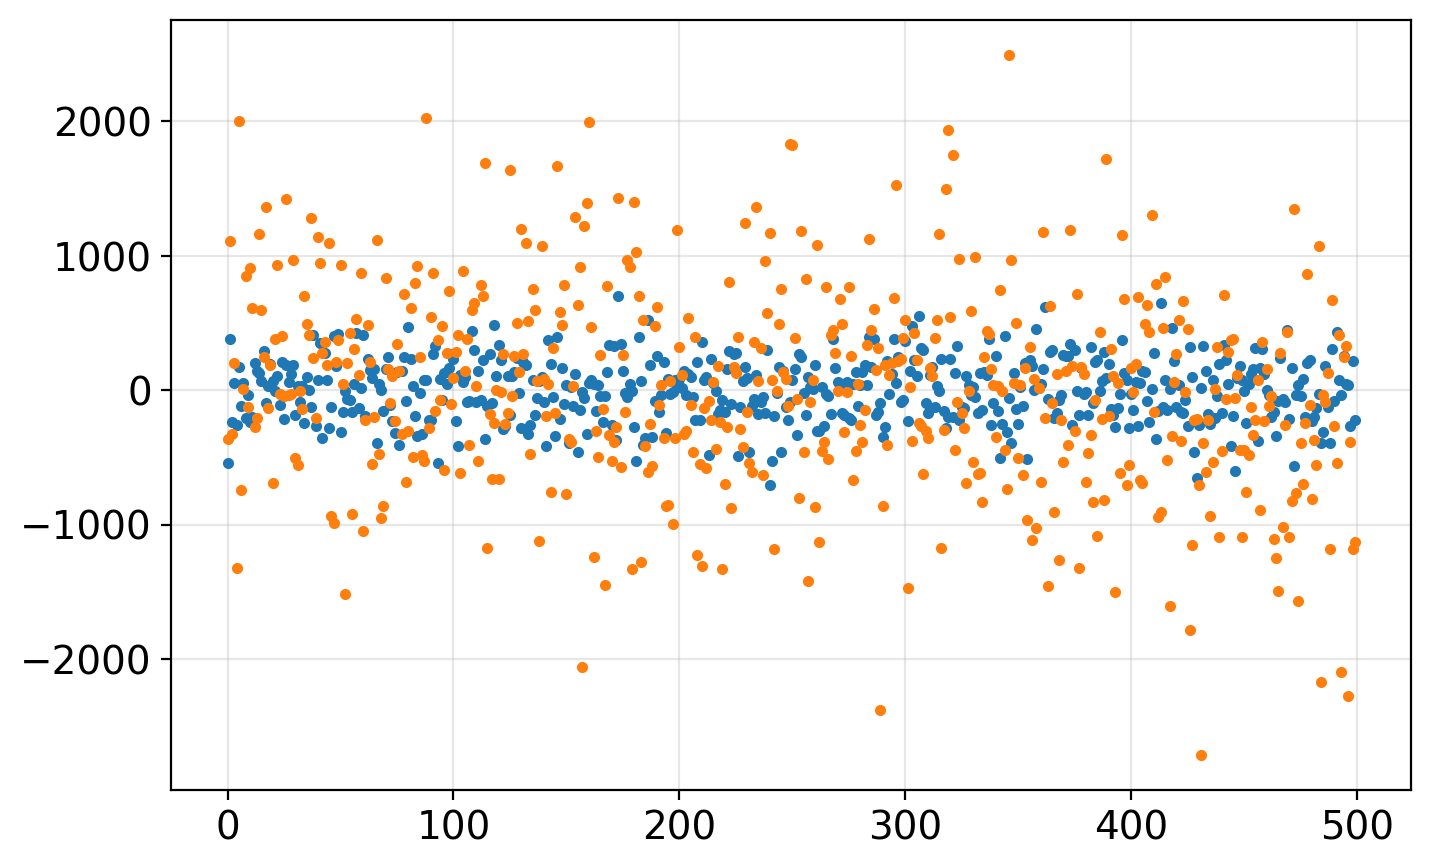

In [41]:
A = counts_v1
#plt.plot(sumall[:2000]- sumall[:2000].mean(),'.')
plt.plot(counts_v1[:1000:2]-counts_v1[:1000:2].mean(),'.')
plt.plot(counts_all[:1000:2]-counts_all[:1000:2].mean(),'.')

np.sqrt(sumall[:2000].mean()), sumall[:2000].std()*4

counts_v1[:1000].mean()/counts_v1[:1000].var(), counts_all[:1000:2].mean()/counts_all[:1000:2].var()

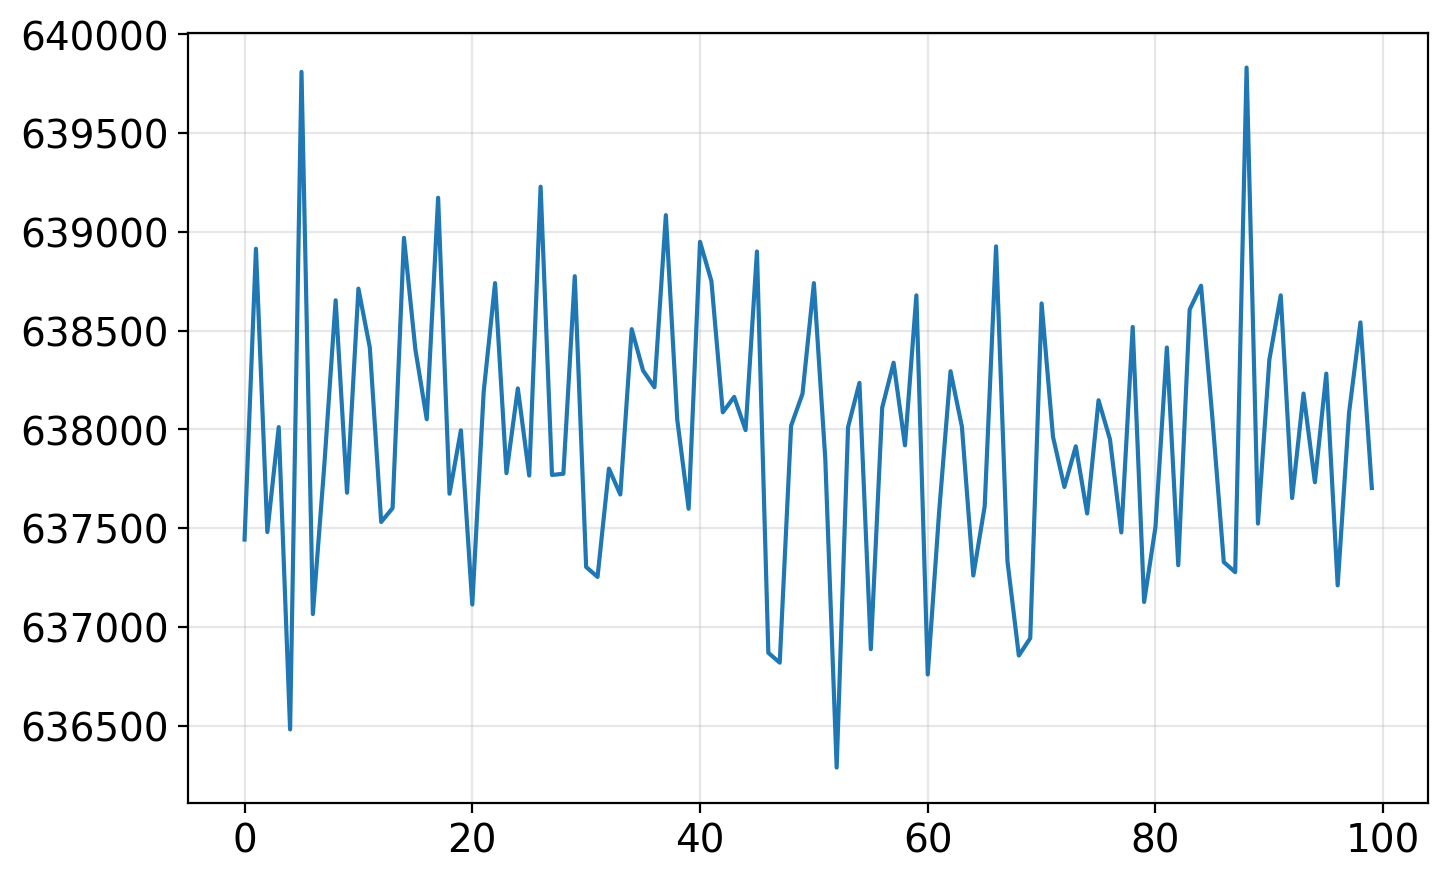

In [35]:
#plt.plot(counts_all[:200])
plt.plot(counts_all[:200:2])

### SENSITIVITY AS A FUNCTION OF TIME

In [30]:
fname = '20240122_scan/Fe20um_Al200um_4steps_2in_clean.dat'

data = pd.read_csv(join(datadir, fname))

#carefu, channels are inverted!


datav1 = data[data['nominal_velocity']==v1].values
datav2 = data[data['nominal_velocity']==v2].values

datav3 = data[data['nominal_velocity']==v3].values
datav4 = data[data['nominal_velocity']==v4].values

sigma_rate_v1 = (datav1['count']/datav1['DAQ_time']).expanding().std().values[1:]
sigma_rate_v2 = (datav2['count']/datav2['DAQ_time']).expanding().std().values[1:]

sigma_rate_v3 = (datav3['count']/datav3['DAQ_time']).expanding().std().values[1:]
sigma_rate_v4 = (datav4['count']/datav4['DAQ_time']).expanding().std().values[1:]

sigma_rate_diff = ((datav1['count']/datav1['DAQ_time']-datav2['count']/datav2['DAQ_time'] + datav3['count']/datav3['DAQ_time']-datav4['count']/datav4['DAQ_time'])).expanding().std().values[1:]

#n = datav1.reset_index().index.values[1:]+1
n = datav1.index.values[1:]+1

delta_rate_v1 = sigma_rate_v1/np.sqrt(n)
delta_rate_v2 = sigma_rate_v2/np.sqrt(n)
delta_rate_v3 = sigma_rate_v3/np.sqrt(n)
delta_rate_v4 = sigma_rate_v4/np.sqrt(n)
delta_rate_diff = sigma_rate_diff/np.sqrt(n)


dt = (datav1['DAQ_time'][1]+datav2['DAQ_time'][1])
time = n*dt


fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()

vels = np.linspace(-1,1,10000)

dRdE_v1 = dlorentzian(p,v1)
dRdE_v2 = dlorentzian(p,v2)
dRdE_v3 = dlorentzian(p,v3)
dRdE_v4 = dlorentzian(p,v4)

dRdE_diff = dRdE_v1 - dRdE_v2 + dRdE_v3 - dRdE_v4


dEmin_v1 = delta_rate_v1/np.abs(dRdE_v1)
dEmin_v2 = delta_rate_v2/np.abs(dRdE_v2)
dEmin_v3 = delta_rate_v3/np.abs(dRdE_v3)
dEmin_v4 = delta_rate_v4/np.abs(dRdE_v4)
dEmin_diff = delta_rate_diff/np.abs(dRdE_diff)


ax.loglog(time, dEmin_v1, 'w--',label = 'single point -')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_v1)/14e3, 'k--',label = 'single point 1')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_v2)/14e3, 'k--',label = 'single point 2')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_v3)/14e3, 'k--',label = 'single point 3')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_v4)/14e3, 'k--',label = 'single point 4')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_diff)/14e3, 'r',label = 'diff')
ax2.set_yscale('log')
ax.set_yscale('log')
#plt.fill_between(time, 1/np.sqrt(n)-1/n, 1/np.sqrt(n)+1/n, color='C2',alpha = 0.5)


plt.xlabel('integration time [h]')
ax.set_ylabel('maximum resonance shift [mm/s]')
ax2.set_ylim(1e-17,1e-14)
ax2.set_ylabel('maximum resonance shift [eV/ev]')

plt.show()


np.savetxt(datadir + fname[:-4]+'_sensitivityvstime.dat', [time,mossbauer.vel_to_E(dEmin_diff)/14e3])
mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00509000e+03, 5.29000000e+01, 1.70596681e+09],
       [5.00000000e+00, 5.00000000e+00, 5.00000000e+00, ...,
        1.00507000e+03, 5.29000000e+01, 1.70596690e+09],
       [9.00000000e+00, 9.00000000e+00, 9.00000000e+00, ...,
        1.00509000e+03, 5.28000000e+01, 1.70596699e+09],
       ...,
       [5.34610000e+04, 5.34630000e+04, 5.34630000e+04, ...,
        1.00570000e+03, 4.64000000e+01, 1.70715529e+09],
       [5.34650000e+04, 5.34670000e+04, 5.34670000e+04, ...,
        1.00572000e+03, 4.64000000e+01, 1.70715537e+09],
       [5.34690000e+04, 5.34710000e+04, 5.34710000e+04, ...,
        1.00573000e+03, 4.64000000e+01, 1.70715546e+09]])

### OTHER PLOTS

(array([   2,    3,    4, ..., 8546, 8547, 8548]),
 array([3.95002188e-15, 4.16482626e-15, 2.97982179e-15, ...,
        6.47431258e-17, 6.47355508e-17, 6.47321268e-17]))

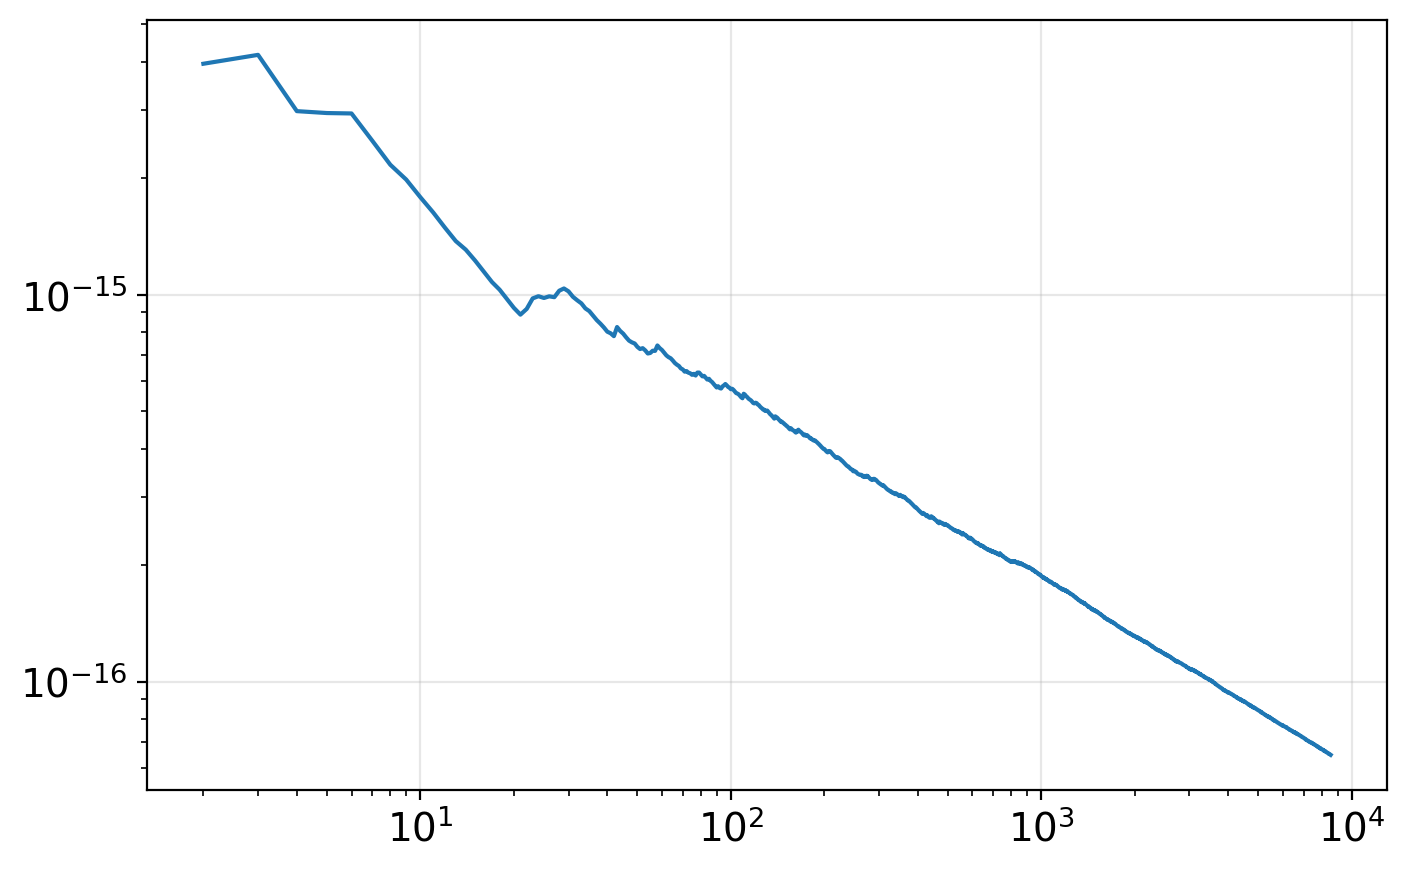

In [147]:
n = pd.Series(diff).index.values[1:]+1
sens = pd.Series(diff).expanding().std()[1:].values/np.sqrt(n)/dRdE_diff/3e11

plt.loglog(n,sens)
n, sens

### Thickness broadening

(0.0, 2.0)

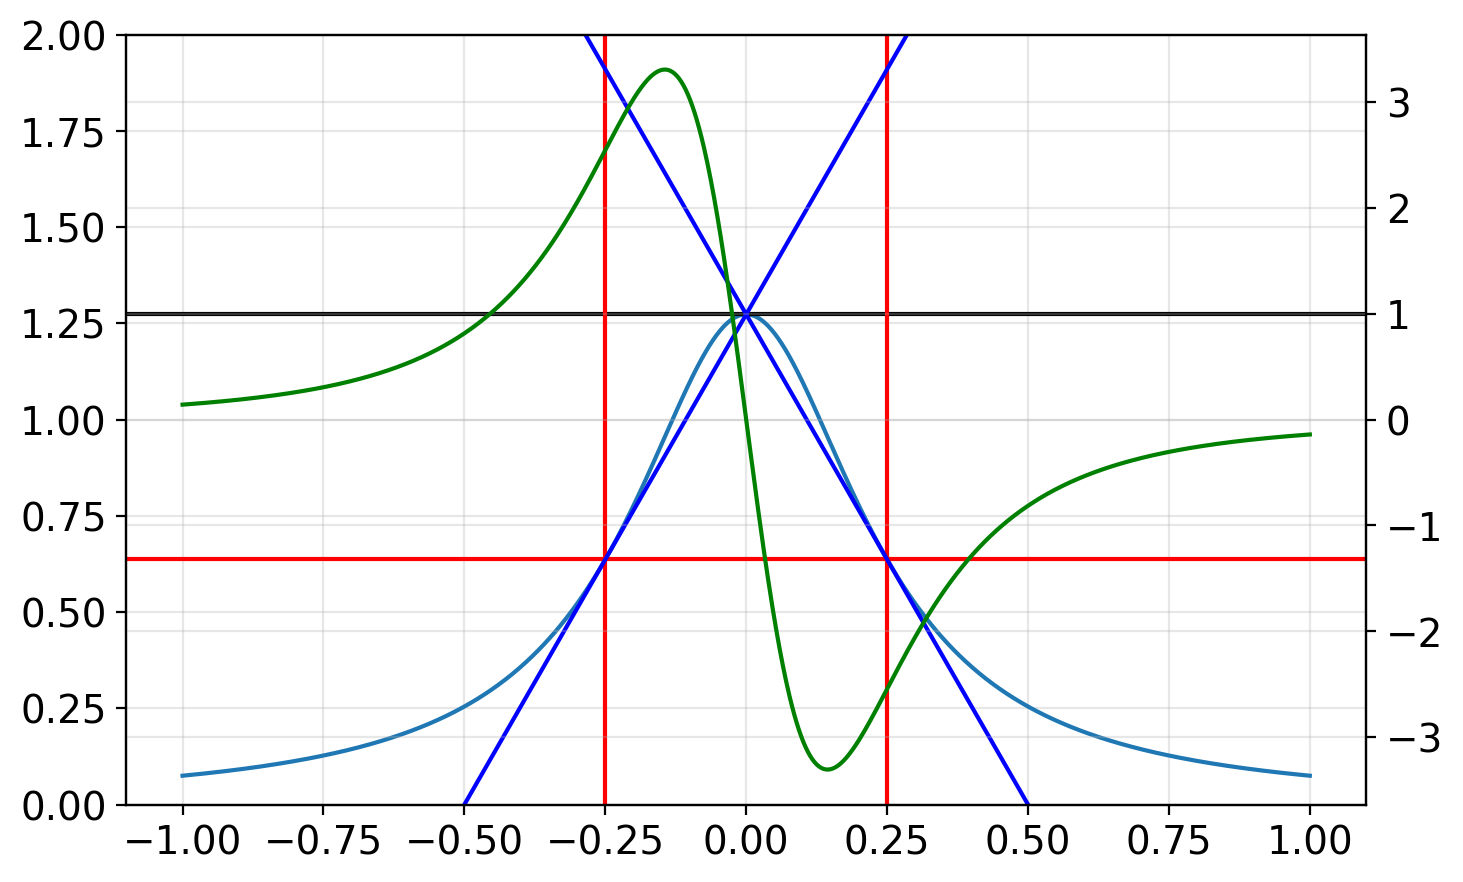

In [67]:
def lorentzian(p,x):
    A, B, E0, Gamma = p
    return 1/np.pi*A*Gamma/2/((x-E0)**2+(Gamma/2)**2)+B

def dlorentzian(p,x):
    A, B, E0, Gamma = p
    return -1/np.pi*A*Gamma*(x-E0)/((x-E0)**2+(Gamma/2)**2)**2



A = 1
B = 0
x0 = 0
Gamma = 0.5

p0=[A, B, x0, Gamma]

x = np.linspace(-1,1,1000)


fig= plt.figure()
ax = plt.gca()
plt.plot(x, lorentzian(p0,x))

plt.axhline(2*A/(np.pi*Gamma),color = 'k')
plt.axhline(2*A/(np.pi*Gamma)/2,color = 'r')
plt.axvline(-Gamma/2, color='r')
plt.axvline(Gamma/2, color='r')
ax2 = ax.twinx()
ax2.plot(x, dlorentzian(p0,x), color = 'g')
ax.plot(x, dlorentzian(p0,-Gamma/2)*(x+Gamma), color = 'b')
ax.plot(x, dlorentzian(p0,Gamma/2)*(x-Gamma), color = 'b')
ax.set_ylim(0,2)

In [60]:
np.linspace(0,10,11).astype('int')*int(5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

In [66]:
50000%(2**15)

17232